In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flood-area-segmentation/metadata.csv
/kaggle/input/flood-area-segmentation/Mask/1017.png
/kaggle/input/flood-area-segmentation/Mask/2015.png
/kaggle/input/flood-area-segmentation/Mask/1084.png
/kaggle/input/flood-area-segmentation/Mask/2021.png
/kaggle/input/flood-area-segmentation/Mask/1012.png
/kaggle/input/flood-area-segmentation/Mask/48.png
/kaggle/input/flood-area-segmentation/Mask/3012.png
/kaggle/input/flood-area-segmentation/Mask/1037.png
/kaggle/input/flood-area-segmentation/Mask/2009.png
/kaggle/input/flood-area-segmentation/Mask/1023.png
/kaggle/input/flood-area-segmentation/Mask/3070.png
/kaggle/input/flood-area-segmentation/Mask/37.png
/kaggle/input/flood-area-segmentation/Mask/1048.png
/kaggle/input/flood-area-segmentation/Mask/3068.png
/kaggle/input/flood-area-segmentation/Mask/1000.png
/kaggle/input/flood-area-segmentation/Mask/35.png
/kaggle/input/flood-area-segmentation/Mask/2030.png
/kaggle/input/flood-area-segmentation/Mask/1081.png
/kaggle/input/flood

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("faizalkarim/flood-area-segmentation")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flood-area-segmentation


In [4]:
# --- 1. CONFIGURATION AND HYPERPARAMETERS ---
CONFIG = {
    'data_dir': '/kaggle/input/flood-area-segmentation/', # Assuming images/, masks/, and metadata.csv are subdirectories/files here
    'metadata_file': 'metadata.csv',
    'image_folder': 'Image',
    'mask_folder': 'Mask',
    'image_size': 256,         # Input size (W x H) for the model. Must be consistent.
    'batch_size': 8,           # Number of images processed per step. Adjust based on GPU VRAM.
    'num_epochs': 50,          # Total passes over the entire dataset.
    'learning_rate': 1e-4,     # Optimizer learning rate.
    'in_channels': 3,          # Input channels (RGB image).
    'out_channels': 1,         # Output channels (1 for binary segmentation: Water/Non-Water).
    'model_save_path': 'unet_best_model.pth',
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}


In [5]:

# --- 2. DATASET AND DATALOADER ---

class FloodDataset(Dataset):
    """Custom Dataset class for loading flood images and segmentation masks."""
    def __init__(self, config):
        self.config = config
        self.df = pd.read_csv(os.path.join(config['data_dir'], config['metadata_file']))
        self.image_paths = [os.path.join(config['data_dir'], config['image_folder'], img_id) 
                            for img_id in self.df['Image']]
        self.mask_paths = [os.path.join(config['data_dir'], config['mask_folder'], mask_id) 
                           for mask_id in self.df['Mask']]
        self.image_size = config['image_size']

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Load Image (RGB)
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load Mask (Grayscale)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        
        if img is None or mask is None:
            raise RuntimeError(f"Could not load image or mask at index {idx}")

        # Preprocessing: Resize and Normalize
        img = cv2.resize(img, (self.image_size, self.image_size))
        mask = cv2.resize(mask, (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST)

        # Normalize image to 0-1 and change to Channel First (PyTorch format)
        img = img.astype(np.float32) / 255.0
        # Convert HWC to CHW format
        img = np.transpose(img, (2, 0, 1)) 

        # Normalize mask to 0 or 1 and convert to PyTorch tensor format
        # Masks should be 1 channel (HxW) and 0 for background, 1 for water
        mask = (mask > 0).astype(np.float32) 
        mask = np.expand_dims(mask, axis=0) # Add channel dimension (1 x H x W)

        # Convert to PyTorch Tensors
        image_tensor = torch.tensor(img, dtype=torch.float32)
        mask_tensor = torch.tensor(mask, dtype=torch.float32)
        
        return image_tensor, mask_tensor


In [6]:

# --- 3. U-NET ARCHITECTURE DEFINITION ---
# The U-Net is a standard, robust choice for segmentation tasks.

class DoubleConv(nn.Module):
    """(Convolution => Batch Norm => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    """The complete U-Net architecture."""
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        # Initial filter depth
        features = [64, 128, 256, 512]
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # --- Encoder (Downsampling Path) ---
        self.enc1 = DoubleConv(in_channels, features[0])
        self.enc2 = DoubleConv(features[0], features[1])
        self.enc3 = DoubleConv(features[1], features[2])
        self.enc4 = DoubleConv(features[2], features[3])
        
        # --- Bottleneck ---
        self.bottleneck = DoubleConv(features[3], features[3] * 2)
        
        # --- Decoder (Upsampling Path) ---
        self.upconv4 = nn.ConvTranspose2d(features[3] * 2, features[3], kernel_size=2, stride=2)
        self.dec4 = DoubleConv(features[3] * 2, features[3])
        
        self.upconv3 = nn.ConvTranspose2d(features[3], features[2], kernel_size=2, stride=2)
        self.dec3 = DoubleConv(features[2] * 2, features[2])
        
        self.upconv2 = nn.ConvTranspose2d(features[2], features[1], kernel_size=2, stride=2)
        self.dec2 = DoubleConv(features[1] * 2, features[1])
        
        self.upconv1 = nn.ConvTranspose2d(features[1], features[0], kernel_size=2, stride=2)
        self.dec1 = DoubleConv(features[0] * 2, features[0])
        
        # --- Final Output ---
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid() # Use Sigmoid for binary classification output (0 to 1)

    def forward(self, x):
        # Encoder
        c1 = self.enc1(x) # 64
        c2 = self.enc2(self.pool(c1)) # 128
        c3 = self.enc3(self.pool(c2)) # 256
        c4 = self.enc4(self.pool(c3)) # 512
        
        # Bottleneck
        b = self.bottleneck(self.pool(c4)) # 1024

        # Decoder (with skip connections)
        d4 = self.upconv4(b)
        # Concatenate with skip connection c4
        d4 = torch.cat((d4, c4), dim=1)
        d4 = self.dec4(d4) # 512

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, c3), dim=1)
        d3 = self.dec3(d3) # 256

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, c2), dim=1)
        d2 = self.dec2(d2) # 128

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, c1), dim=1)
        d1 = self.dec1(d1) # 64
        
        # Final output
        output = self.final_conv(d1)
        
        return self.sigmoid(output)


In [7]:

# --- 4. TRAINING FUNCTION ---

def train_model(model, data_loader, criterion, optimizer, config):
    """
    Main loop for training the U-Net model.
    """
    model.train() # Set model to training mode
    running_loss = 0.0
    
    # Iterate over the data loader using tqdm for progress tracking
    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch}/{config['num_epochs']}", unit="batch")
    
    for inputs, targets in progress_bar:
        # Move data to the configured device (GPU/CPU)
        inputs = inputs.to(config['device'])
        targets = targets.to(config['device'])

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        
        # Update progress bar description
        progress_bar.set_postfix({'loss': loss.item()})

    epoch_loss = running_loss / len(data_loader.dataset)
    return epoch_loss


Using device: cpu
Total Images: 290. Training: 232, Validation: 58


Epoch 1/50: 100%|██████████| 29/29 [11:51<00:00, 24.54s/batch, loss=0.397]


Epoch 1: Train Loss: 0.4847 | Val Loss: 1.0516
Validation loss improved. Saving model to unet_best_model.pth


Epoch 2/50: 100%|██████████| 29/29 [11:50<00:00, 24.49s/batch, loss=0.437]


Epoch 2: Train Loss: 0.3873 | Val Loss: 0.4555
Validation loss improved. Saving model to unet_best_model.pth


Epoch 3/50: 100%|██████████| 29/29 [11:47<00:00, 24.38s/batch, loss=0.396]


Epoch 3: Train Loss: 0.3663 | Val Loss: 0.3507
Validation loss improved. Saving model to unet_best_model.pth


Epoch 4/50: 100%|██████████| 29/29 [11:50<00:00, 24.49s/batch, loss=0.305]


Epoch 4: Train Loss: 0.3489 | Val Loss: 0.3408
Validation loss improved. Saving model to unet_best_model.pth


Epoch 5/50: 100%|██████████| 29/29 [11:45<00:00, 24.34s/batch, loss=0.4]


Epoch 5: Train Loss: 0.3426 | Val Loss: 0.3623


Epoch 6/50: 100%|██████████| 29/29 [11:42<00:00, 24.23s/batch, loss=0.381]


Epoch 6: Train Loss: 0.3206 | Val Loss: 0.3481


Epoch 7/50: 100%|██████████| 29/29 [11:46<00:00, 24.37s/batch, loss=0.321]


Epoch 7: Train Loss: 0.3283 | Val Loss: 0.3242
Validation loss improved. Saving model to unet_best_model.pth


Epoch 8/50: 100%|██████████| 29/29 [11:47<00:00, 24.39s/batch, loss=0.276]


Epoch 8: Train Loss: 0.3197 | Val Loss: 0.4328


Epoch 9/50: 100%|██████████| 29/29 [11:44<00:00, 24.31s/batch, loss=0.254]


Epoch 9: Train Loss: 0.3122 | Val Loss: 0.3011
Validation loss improved. Saving model to unet_best_model.pth


Epoch 10/50: 100%|██████████| 29/29 [11:55<00:00, 24.69s/batch, loss=0.29]


Epoch 10: Train Loss: 0.3047 | Val Loss: 0.3443


Epoch 11/50: 100%|██████████| 29/29 [11:45<00:00, 24.33s/batch, loss=0.261]


Epoch 11: Train Loss: 0.2924 | Val Loss: 0.3104


Epoch 12/50: 100%|██████████| 29/29 [12:01<00:00, 24.87s/batch, loss=0.242]


Epoch 12: Train Loss: 0.2944 | Val Loss: 0.3107


Epoch 13/50: 100%|██████████| 29/29 [11:48<00:00, 24.43s/batch, loss=0.222]


Epoch 13: Train Loss: 0.2774 | Val Loss: 0.3137


Epoch 14/50: 100%|██████████| 29/29 [11:53<00:00, 24.61s/batch, loss=0.216]


Epoch 14: Train Loss: 0.2690 | Val Loss: 0.2814
Validation loss improved. Saving model to unet_best_model.pth


Epoch 15/50: 100%|██████████| 29/29 [11:45<00:00, 24.34s/batch, loss=0.402]


Epoch 15: Train Loss: 0.2749 | Val Loss: 0.3282


Epoch 16/50: 100%|██████████| 29/29 [11:49<00:00, 24.47s/batch, loss=0.217]


Epoch 16: Train Loss: 0.2847 | Val Loss: 0.2894


Epoch 17/50: 100%|██████████| 29/29 [11:45<00:00, 24.32s/batch, loss=0.35]


Epoch 17: Train Loss: 0.2814 | Val Loss: 0.2993


Epoch 18/50: 100%|██████████| 29/29 [11:59<00:00, 24.81s/batch, loss=0.253]


Epoch 18: Train Loss: 0.2646 | Val Loss: 0.3022


Epoch 19/50: 100%|██████████| 29/29 [11:53<00:00, 24.62s/batch, loss=0.233]


Epoch 19: Train Loss: 0.2561 | Val Loss: 0.2583
Validation loss improved. Saving model to unet_best_model.pth


Epoch 20/50: 100%|██████████| 29/29 [11:48<00:00, 24.44s/batch, loss=0.201]


Epoch 20: Train Loss: 0.2486 | Val Loss: 0.2686


Epoch 21/50: 100%|██████████| 29/29 [11:59<00:00, 24.80s/batch, loss=0.267]


Epoch 21: Train Loss: 0.2544 | Val Loss: 0.2707


Epoch 22/50: 100%|██████████| 29/29 [11:56<00:00, 24.71s/batch, loss=0.197]


Epoch 22: Train Loss: 0.2638 | Val Loss: 0.2600


Epoch 23/50: 100%|██████████| 29/29 [11:44<00:00, 24.30s/batch, loss=0.211]


Epoch 23: Train Loss: 0.2428 | Val Loss: 0.2707


Epoch 24/50: 100%|██████████| 29/29 [11:45<00:00, 24.34s/batch, loss=0.194]


Epoch 24: Train Loss: 0.2354 | Val Loss: 0.2957


Epoch 25/50: 100%|██████████| 29/29 [11:39<00:00, 24.12s/batch, loss=0.217]


Epoch 25: Train Loss: 0.2394 | Val Loss: 0.3010


Epoch 26/50: 100%|██████████| 29/29 [11:46<00:00, 24.35s/batch, loss=0.205]


Epoch 26: Train Loss: 0.2407 | Val Loss: 0.2652


Epoch 27/50: 100%|██████████| 29/29 [11:45<00:00, 24.34s/batch, loss=0.217]


Epoch 27: Train Loss: 0.2421 | Val Loss: 0.2545
Validation loss improved. Saving model to unet_best_model.pth


Epoch 28/50: 100%|██████████| 29/29 [11:42<00:00, 24.23s/batch, loss=0.242]


Epoch 28: Train Loss: 0.2535 | Val Loss: 0.2856


Epoch 29/50: 100%|██████████| 29/29 [11:45<00:00, 24.32s/batch, loss=0.222]


Epoch 29: Train Loss: 0.2366 | Val Loss: 0.2813


Epoch 30/50: 100%|██████████| 29/29 [11:38<00:00, 24.09s/batch, loss=0.22]


Epoch 30: Train Loss: 0.2233 | Val Loss: 0.2635


Epoch 31/50: 100%|██████████| 29/29 [11:41<00:00, 24.20s/batch, loss=0.217]


Epoch 31: Train Loss: 0.2184 | Val Loss: 0.3358


Epoch 32/50: 100%|██████████| 29/29 [11:41<00:00, 24.19s/batch, loss=0.203]


Epoch 32: Train Loss: 0.2266 | Val Loss: 0.2804


Epoch 33/50: 100%|██████████| 29/29 [11:41<00:00, 24.19s/batch, loss=0.316]


Epoch 33: Train Loss: 0.2203 | Val Loss: 0.2603


Epoch 34/50: 100%|██████████| 29/29 [11:39<00:00, 24.12s/batch, loss=0.278]


Epoch 34: Train Loss: 0.2100 | Val Loss: 0.2492
Validation loss improved. Saving model to unet_best_model.pth


Epoch 35/50: 100%|██████████| 29/29 [11:36<00:00, 24.03s/batch, loss=0.162]


Epoch 35: Train Loss: 0.2068 | Val Loss: 0.2663


Epoch 36/50: 100%|██████████| 29/29 [11:34<00:00, 23.94s/batch, loss=0.138]


Epoch 36: Train Loss: 0.2028 | Val Loss: 0.2528


Epoch 37/50: 100%|██████████| 29/29 [11:37<00:00, 24.04s/batch, loss=0.175]


Epoch 37: Train Loss: 0.1900 | Val Loss: 0.3015


Epoch 38/50: 100%|██████████| 29/29 [11:34<00:00, 23.95s/batch, loss=0.147]


Epoch 38: Train Loss: 0.1905 | Val Loss: 0.2778


Epoch 39/50: 100%|██████████| 29/29 [11:33<00:00, 23.91s/batch, loss=0.293]


Epoch 39: Train Loss: 0.1909 | Val Loss: 0.2580


Epoch 40/50: 100%|██████████| 29/29 [11:34<00:00, 23.95s/batch, loss=0.175]


Epoch 40: Train Loss: 0.2001 | Val Loss: 0.3306


Epoch 41/50: 100%|██████████| 29/29 [11:34<00:00, 23.95s/batch, loss=0.249]


Epoch 41: Train Loss: 0.1944 | Val Loss: 0.3142


Epoch 42/50: 100%|██████████| 29/29 [11:37<00:00, 24.05s/batch, loss=0.149]


Epoch 42: Train Loss: 0.1829 | Val Loss: 0.2436
Validation loss improved. Saving model to unet_best_model.pth


Epoch 43/50: 100%|██████████| 29/29 [11:32<00:00, 23.86s/batch, loss=0.186]


Epoch 43: Train Loss: 0.1715 | Val Loss: 0.2395
Validation loss improved. Saving model to unet_best_model.pth


Epoch 44/50: 100%|██████████| 29/29 [11:32<00:00, 23.89s/batch, loss=0.315]


Epoch 44: Train Loss: 0.1705 | Val Loss: 0.2681


Epoch 45/50: 100%|██████████| 29/29 [11:37<00:00, 24.05s/batch, loss=0.208]


Epoch 45: Train Loss: 0.1722 | Val Loss: 0.2535


Epoch 46/50: 100%|██████████| 29/29 [11:30<00:00, 23.81s/batch, loss=0.232]


Epoch 46: Train Loss: 0.1653 | Val Loss: 0.2641


Epoch 47/50: 100%|██████████| 29/29 [11:34<00:00, 23.96s/batch, loss=0.148]


Epoch 47: Train Loss: 0.1678 | Val Loss: 0.2338
Validation loss improved. Saving model to unet_best_model.pth


Epoch 48/50: 100%|██████████| 29/29 [11:34<00:00, 23.94s/batch, loss=0.152]


Epoch 48: Train Loss: 0.1599 | Val Loss: 0.2925


Epoch 49/50: 100%|██████████| 29/29 [11:38<00:00, 24.07s/batch, loss=0.143]


Epoch 49: Train Loss: 0.1641 | Val Loss: 0.2635


Epoch 50/50: 100%|██████████| 29/29 [11:44<00:00, 24.28s/batch, loss=0.18]


Epoch 50: Train Loss: 0.1594 | Val Loss: 0.2666

Training complete.
Loss plot saved as training_loss_plot.png


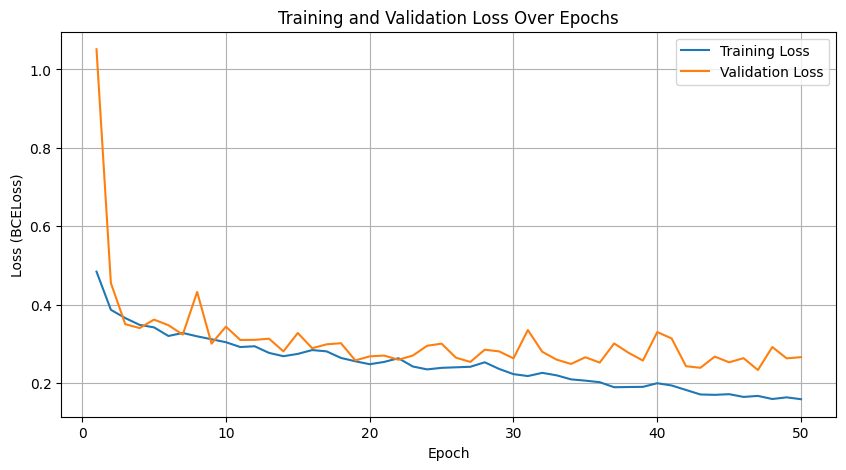

In [8]:
# --- 5. MAIN EXECUTION ---

if __name__ == "__main__":
    print(f"Using device: {CONFIG['device']}")
    
    # Check for metadata file before proceeding
    if not os.path.exists(os.path.join(CONFIG['data_dir'], CONFIG['metadata_file'])):
        print(f"Error: Metadata file {CONFIG['metadata_dir']} not found. Cannot load dataset.")
    elif not os.path.exists(os.path.join(CONFIG['data_dir'], CONFIG['image_folder'])) or \
         not os.path.exists(os.path.join(CONFIG['data_dir'], CONFIG['mask_folder'])):
        print("Error: Image or Mask folders not found. Check directory structure.")
    else:
        # 1. Load Data
        full_dataset = FloodDataset(CONFIG)
        
        # Split data into training and validation sets (80/20 split)
        train_size = int(0.8 * len(full_dataset))
        val_size = len(full_dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
        
        train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=os.cpu_count())
        val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=os.cpu_count())
        
        print(f"Total Images: {len(full_dataset)}. Training: {train_size}, Validation: {val_size}")

        # 2. Initialize Model
        model = UNet(CONFIG['in_channels'], CONFIG['out_channels']).to(CONFIG['device'])
        
        # 3. Define Loss Function and Optimizer
        # Binary Cross-Entropy with Logits (BCEWithLogitsLoss) is common for binary segmentation,
        # but since we used Sigmoid in the UNet forward pass, we use standard BCE loss.
        criterion = nn.BCELoss() 
        optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])

        # 4. Training Loop
        best_loss = float('inf')
        train_losses = []
        val_losses = []
        
        for epoch in range(1, CONFIG['num_epochs'] + 1):
            
            # --- Training Step ---
            train_loss = train_model(model, train_loader, criterion, optimizer, CONFIG)
            train_losses.append(train_loss)
            
            # --- Validation Step ---
            model.eval() # Set model to evaluation mode
            val_loss = 0.0
            with torch.no_grad(): # Disable gradient calculations during validation
                for inputs, targets in val_loader:
                    inputs = inputs.to(CONFIG['device'])
                    targets = targets.to(CONFIG['device'])
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)
            
            val_loss /= len(val_loader.dataset)
            val_losses.append(val_loss)

            print(f"Epoch {epoch}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

            # 5. Model Saving (Hyperparameter Tuning for early stopping/best model)
            # Save the model checkpoint if validation loss improves
            if val_loss < best_loss:
                best_loss = val_loss
                print(f"Validation loss improved. Saving model to {CONFIG['model_save_path']}")
                torch.save(model.state_dict(), CONFIG['model_save_path'])

        print("\nTraining complete.")

        # Optional: Plotting results for portfolio
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, CONFIG['num_epochs'] + 1), train_losses, label='Training Loss')
        plt.plot(range(1, CONFIG['num_epochs'] + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (BCELoss)')
        plt.title('Training and Validation Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.savefig('training_loss_plot.png')
        print("Loss plot saved as training_loss_plot.png")